In [1]:
import argparse
import numpy as np
import matplotlib as mpl
import torch
from torch import nn, optim
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from preprocessing import *
from discharge_model import Predictor
from utils import loss_profile, model_evaluation, adjust_learning_rate
torch.manual_seed(2022)

In [2]:
def get_args_parser():
    """hyperparameter & model setting""" 
    parser = argparse.ArgumentParser('Discharge model(QV-curve) training', add_help=False)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--epochs', default=1000, type=int)
    parser.add_argument('--split_seed', default=0, type=int)
    parser.add_argument('--gpu_id', default=0, type=int)
    parser.add_argument('--detail_epoch', default=1, type=int)

    # Model parameters
    parser.add_argument('--model', default='Predictor_1', type=str, metavar='MODEL')
    parser.add_argument('--checkpoint', default='checkpoint/pretrain_predictor.pth', type=str)
    parser.add_argument('--drop', default=0.20, type=float)
    parser.add_argument('--qv_ch', default=64, type=int)
    parser.add_argument('--savepath', default='checkpoint/best_predictor.pth', type=str)
    parser.add_argument('--finetune', default=False, type=bool)
    parser.add_argument('--pretrained_model', default='checkpoint/best_38p55.pth', type=str)

    # Optimizer parameters
    parser.add_argument('--weight_decay', type=float, default=1e-2, metavar='LR')
    parser.add_argument('--lr', type=float, default=1e-4, metavar='LR')
    parser.add_argument('--lr_schedule', type=bool, default=True, metavar='LR')
    parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR')
    parser.add_argument('--lr_period', type=int, default=10, metavar='LR')

    return parser

 -- GPU is available -- 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 50]          45,120
              Mish-2               [-1, 64, 50]               0
            Conv1d-3              [-1, 128, 50]          57,472
              Mish-4              [-1, 128, 50]               0
            Conv1d-5              [-1, 256, 50]         164,096
              Mish-6              [-1, 256, 50]               0
    SpatialDropout-7              [-1, 256, 50]               0
         AvgPool1d-8              [-1, 256, 25]               0
            Conv1d-9               [-1, 64, 25]         180,288
             Mish-10               [-1, 64, 25]               0
           Conv1d-11               [-1, 64, 25]         114,752
             Mish-12               [-1, 64, 25]               0
        AvgPool1d-13                [-1, 64, 1]               0
        AvgPoo

epoch:[17 / 1000] batch:[30 / 134] loss= 0.273
epoch:[17 / 1000] batch:[60 / 134] loss= 0.151
epoch:[17 / 1000] batch:[90 / 134] loss= 0.243
epoch:[17 / 1000] batch:[120 / 134] loss= 0.246
100 cycles trn_loss: 0.191, val_loss: 0.230, lr=7.959537e-05
training set RMSE 1 cycle: 101.818, 10 cycle: 67.378, 100 cycle: 60.078
testing set RMSE 1 cycle: 71.323, 10 cycle: 70.225, 100 cycle: 63.358
epoch:[18 / 1000] batch:[30 / 134] loss= 0.115
epoch:[18 / 1000] batch:[60 / 134] loss= 0.170
epoch:[18 / 1000] batch:[90 / 134] loss= 0.192
epoch:[18 / 1000] batch:[120 / 134] loss= 0.218
100 cycles trn_loss: 0.191, val_loss: 0.270, lr=9.054634e-05
training set RMSE 1 cycle: 97.121, 10 cycle: 64.298, 100 cycle: 63.673
testing set RMSE 1 cycle: 73.910, 10 cycle: 71.836, 100 cycle: 70.630
epoch:[19 / 1000] batch:[30 / 134] loss= 0.174
epoch:[19 / 1000] batch:[60 / 134] loss= 0.129
epoch:[19 / 1000] batch:[90 / 134] loss= 0.345
epoch:[19 / 1000] batch:[120 / 134] loss= 0.233
100 cycles trn_loss: 0.258, 

epoch:[38 / 1000] batch:[30 / 134] loss= 0.137
epoch:[38 / 1000] batch:[60 / 134] loss= 0.364
epoch:[38 / 1000] batch:[90 / 134] loss= 0.162
epoch:[38 / 1000] batch:[120 / 134] loss= 0.165
100 cycles trn_loss: 0.155, val_loss: 0.233, lr=9.054634e-05
training set RMSE 1 cycle: 86.293, 10 cycle: 60.082, 100 cycle: 56.089
testing set RMSE 1 cycle: 68.543, 10 cycle: 66.874, 100 cycle: 64.027
epoch:[39 / 1000] batch:[30 / 134] loss= 0.212
epoch:[39 / 1000] batch:[60 / 134] loss= 0.125
epoch:[39 / 1000] batch:[90 / 134] loss= 0.257
epoch:[39 / 1000] batch:[120 / 134] loss= 0.210
100 cycles trn_loss: 0.227, val_loss: 0.307, lr=9.757730e-05
training set RMSE 1 cycle: 87.690, 10 cycle: 70.581, 100 cycle: 71.325
testing set RMSE 1 cycle: 77.022, 10 cycle: 77.339, 100 cycle: 77.906
epoch:[40 / 1000] batch:[30 / 134] loss= 0.200
epoch:[40 / 1000] batch:[60 / 134] loss= 0.080
epoch:[40 / 1000] batch:[90 / 134] loss= 0.129
epoch:[40 / 1000] batch:[120 / 134] loss= 0.257
100 cycles trn_loss: 0.159, v

epoch:[59 / 1000] batch:[30 / 134] loss= 0.182
epoch:[59 / 1000] batch:[60 / 134] loss= 0.226
epoch:[59 / 1000] batch:[90 / 134] loss= 0.112
epoch:[59 / 1000] batch:[120 / 134] loss= 0.101
100 cycles trn_loss: 0.128, val_loss: 0.204, lr=9.757730e-05
training set RMSE 1 cycle: 81.028, 10 cycle: 57.338, 100 cycle: 51.460
testing set RMSE 1 cycle: 67.953, 10 cycle: 63.242, 100 cycle: 59.845
epoch:[60 / 1000] batch:[30 / 134] loss= 0.220
epoch:[60 / 1000] batch:[60 / 134] loss= 0.118
epoch:[60 / 1000] batch:[90 / 134] loss= 0.190
epoch:[60 / 1000] batch:[120 / 134] loss= 0.218
100 cycles trn_loss: 0.162, val_loss: 0.251, lr=1.000000e-04
training set RMSE 1 cycle: 79.146, 10 cycle: 60.612, 100 cycle: 59.033
testing set RMSE 1 cycle: 70.484, 10 cycle: 67.254, 100 cycle: 67.742
epoch:[61 / 1000] batch:[30 / 134] loss= 0.194
epoch:[61 / 1000] batch:[60 / 134] loss= 0.226
epoch:[61 / 1000] batch:[90 / 134] loss= 0.186
epoch:[61 / 1000] batch:[120 / 134] loss= 0.047
100 cycles trn_loss: 0.129, v

epoch:[80 / 1000] batch:[30 / 134] loss= 0.160
epoch:[80 / 1000] batch:[60 / 134] loss= 0.105
epoch:[80 / 1000] batch:[90 / 134] loss= 0.203
epoch:[80 / 1000] batch:[120 / 134] loss= 0.150
100 cycles trn_loss: 0.140, val_loss: 0.197, lr=1.000000e-04
training set RMSE 1 cycle: 81.816, 10 cycle: 64.357, 100 cycle: 51.128
testing set RMSE 1 cycle: 68.527, 10 cycle: 66.571, 100 cycle: 58.779
epoch:[81 / 1000] batch:[30 / 134] loss= 0.091
epoch:[81 / 1000] batch:[60 / 134] loss= 0.145
epoch:[81 / 1000] batch:[90 / 134] loss= 0.101
epoch:[81 / 1000] batch:[120 / 134] loss= 0.207
100 cycles trn_loss: 0.113, val_loss: 0.187, lr=9.757730e-05
training set RMSE 1 cycle: 75.421, 10 cycle: 56.883, 100 cycle: 47.253
testing set RMSE 1 cycle: 65.290, 10 cycle: 63.389, 100 cycle: 57.157
epoch:[82 / 1000] batch:[30 / 134] loss= 0.157
epoch:[82 / 1000] batch:[60 / 134] loss= 0.227
epoch:[82 / 1000] batch:[90 / 134] loss= 0.083
epoch:[82 / 1000] batch:[120 / 134] loss= 0.309
100 cycles trn_loss: 0.189, v

epoch:[101 / 1000] batch:[30 / 134] loss= 0.245
epoch:[101 / 1000] batch:[60 / 134] loss= 0.220
epoch:[101 / 1000] batch:[90 / 134] loss= 0.175
epoch:[101 / 1000] batch:[120 / 134] loss= 0.181
100 cycles trn_loss: 0.126, val_loss: 0.196, lr=9.757730e-05
training set RMSE 1 cycle: 69.061, 10 cycle: 53.891, 100 cycle: 51.457
testing set RMSE 1 cycle: 60.344, 10 cycle: 58.568, 100 cycle: 58.441
epoch:[102 / 1000] batch:[30 / 134] loss= 0.079
epoch:[102 / 1000] batch:[60 / 134] loss= 0.095
epoch:[102 / 1000] batch:[90 / 134] loss= 0.126
epoch:[102 / 1000] batch:[120 / 134] loss= 0.162
100 cycles trn_loss: 0.104, val_loss: 0.151, lr=9.054634e-05
training set RMSE 1 cycle: 68.147, 10 cycle: 56.006, 100 cycle: 44.838
testing set RMSE 1 cycle: 60.976, 10 cycle: 58.832, 100 cycle: 51.121
epoch:[103 / 1000] batch:[30 / 134] loss= 0.115
epoch:[103 / 1000] batch:[60 / 134] loss= 0.120
epoch:[103 / 1000] batch:[90 / 134] loss= 0.175
epoch:[103 / 1000] batch:[120 / 134] loss= 0.114
100 cycles trn_lo

epoch:[122 / 1000] batch:[30 / 134] loss= 0.093
epoch:[122 / 1000] batch:[60 / 134] loss= 0.089
epoch:[122 / 1000] batch:[90 / 134] loss= 0.040
epoch:[122 / 1000] batch:[120 / 134] loss= 0.095
100 cycles trn_loss: 0.114, val_loss: 0.129, lr=9.054634e-05
training set RMSE 1 cycle: 64.888, 10 cycle: 59.631, 100 cycle: 46.011
testing set RMSE 1 cycle: 59.940, 10 cycle: 57.398, 100 cycle: 47.200
epoch:[123 / 1000] batch:[30 / 134] loss= 0.308
epoch:[123 / 1000] batch:[60 / 134] loss= 0.151
epoch:[123 / 1000] batch:[90 / 134] loss= 0.144
epoch:[123 / 1000] batch:[120 / 134] loss= 0.166
100 cycles trn_loss: 0.158, val_loss: 0.254, lr=7.959537e-05
training set RMSE 1 cycle: 63.823, 10 cycle: 57.745, 100 cycle: 58.202
testing set RMSE 1 cycle: 65.133, 10 cycle: 63.449, 100 cycle: 67.172
epoch:[124 / 1000] batch:[30 / 134] loss= 0.126
epoch:[124 / 1000] batch:[60 / 134] loss= 0.059
epoch:[124 / 1000] batch:[90 / 134] loss= 0.131
epoch:[124 / 1000] batch:[120 / 134] loss= 0.140
100 cycles trn_lo

epoch:[143 / 1000] batch:[30 / 134] loss= 0.105
epoch:[143 / 1000] batch:[60 / 134] loss= 0.102
epoch:[143 / 1000] batch:[90 / 134] loss= 0.093
epoch:[143 / 1000] batch:[120 / 134] loss= 0.070
100 cycles trn_loss: 0.119, val_loss: 0.174, lr=7.959537e-05
training set RMSE 1 cycle: 50.529, 10 cycle: 50.362, 100 cycle: 49.483
testing set RMSE 1 cycle: 56.295, 10 cycle: 54.385, 100 cycle: 55.105
epoch:[144 / 1000] batch:[30 / 134] loss= 0.210
epoch:[144 / 1000] batch:[60 / 134] loss= 0.280
epoch:[144 / 1000] batch:[90 / 134] loss= 0.173
epoch:[144 / 1000] batch:[120 / 134] loss= 0.132
100 cycles trn_loss: 0.121, val_loss: 0.192, lr=6.579634e-05
training set RMSE 1 cycle: 53.303, 10 cycle: 51.514, 100 cycle: 50.637
testing set RMSE 1 cycle: 57.915, 10 cycle: 55.147, 100 cycle: 57.778
epoch:[145 / 1000] batch:[30 / 134] loss= 0.117
epoch:[145 / 1000] batch:[60 / 134] loss= 0.105
epoch:[145 / 1000] batch:[90 / 134] loss= 0.141
epoch:[145 / 1000] batch:[120 / 134] loss= 0.049
100 cycles trn_lo

epoch:[164 / 1000] batch:[30 / 134] loss= 0.177
epoch:[164 / 1000] batch:[60 / 134] loss= 0.145
epoch:[164 / 1000] batch:[90 / 134] loss= 0.147
epoch:[164 / 1000] batch:[120 / 134] loss= 0.125
100 cycles trn_loss: 0.118, val_loss: 0.207, lr=6.579634e-05
training set RMSE 1 cycle: 46.736, 10 cycle: 47.803, 100 cycle: 48.572
testing set RMSE 1 cycle: 58.467, 10 cycle: 57.919, 100 cycle: 60.342
epoch:[165 / 1000] batch:[30 / 134] loss= 0.116
epoch:[165 / 1000] batch:[60 / 134] loss= 0.106
epoch:[165 / 1000] batch:[90 / 134] loss= 0.089
epoch:[165 / 1000] batch:[120 / 134] loss= 0.039
100 cycles trn_loss: 0.082, val_loss: 0.119, lr=5.050000e-05
training set RMSE 1 cycle: 49.059, 10 cycle: 46.184, 100 cycle: 40.013
testing set RMSE 1 cycle: 50.866, 10 cycle: 50.075, 100 cycle: 45.347
epoch:[166 / 1000] batch:[30 / 134] loss= 0.104
epoch:[166 / 1000] batch:[60 / 134] loss= 0.070
epoch:[166 / 1000] batch:[90 / 134] loss= 0.094
epoch:[166 / 1000] batch:[120 / 134] loss= 0.094
100 cycles trn_lo

epoch:[185 / 1000] batch:[30 / 134] loss= 0.060
epoch:[185 / 1000] batch:[60 / 134] loss= 0.066
epoch:[185 / 1000] batch:[90 / 134] loss= 0.044
epoch:[185 / 1000] batch:[120 / 134] loss= 0.068
100 cycles trn_loss: 0.082, val_loss: 0.149, lr=5.050000e-05
training set RMSE 1 cycle: 50.389, 10 cycle: 49.370, 100 cycle: 39.584
testing set RMSE 1 cycle: 56.783, 10 cycle: 57.571, 100 cycle: 50.929
epoch:[186 / 1000] batch:[30 / 134] loss= 0.084
epoch:[186 / 1000] batch:[60 / 134] loss= 0.116
epoch:[186 / 1000] batch:[90 / 134] loss= 0.149
epoch:[186 / 1000] batch:[120 / 134] loss= 0.078
100 cycles trn_loss: 0.077, val_loss: 0.131, lr=3.520366e-05
training set RMSE 1 cycle: 44.471, 10 cycle: 42.907, 100 cycle: 38.241
testing set RMSE 1 cycle: 53.845, 10 cycle: 50.907, 100 cycle: 47.680
epoch:[187 / 1000] batch:[30 / 134] loss= 0.099
epoch:[187 / 1000] batch:[60 / 134] loss= 0.127
epoch:[187 / 1000] batch:[90 / 134] loss= 0.127
epoch:[187 / 1000] batch:[120 / 134] loss= 0.120
100 cycles trn_lo

epoch:[206 / 1000] batch:[30 / 134] loss= 0.029
epoch:[206 / 1000] batch:[60 / 134] loss= 0.046
epoch:[206 / 1000] batch:[90 / 134] loss= 0.052
epoch:[206 / 1000] batch:[120 / 134] loss= 0.105
100 cycles trn_loss: 0.092, val_loss: 0.117, lr=3.520366e-05
training set RMSE 1 cycle: 44.766, 10 cycle: 43.553, 100 cycle: 42.600
testing set RMSE 1 cycle: 52.009, 10 cycle: 43.718, 100 cycle: 45.122
epoch:[207 / 1000] batch:[30 / 134] loss= 0.053
epoch:[207 / 1000] batch:[60 / 134] loss= 0.102
epoch:[207 / 1000] batch:[90 / 134] loss= 0.045
epoch:[207 / 1000] batch:[120 / 134] loss= 0.076
100 cycles trn_loss: 0.073, val_loss: 0.131, lr=2.140463e-05
training set RMSE 1 cycle: 44.801, 10 cycle: 42.690, 100 cycle: 37.231
testing set RMSE 1 cycle: 52.485, 10 cycle: 54.407, 100 cycle: 47.724
epoch:[208 / 1000] batch:[30 / 134] loss= 0.044
epoch:[208 / 1000] batch:[60 / 134] loss= 0.101
epoch:[208 / 1000] batch:[90 / 134] loss= 0.082
epoch:[208 / 1000] batch:[120 / 134] loss= 0.103
100 cycles trn_lo

epoch:[227 / 1000] batch:[30 / 134] loss= 0.072
epoch:[227 / 1000] batch:[60 / 134] loss= 0.051
epoch:[227 / 1000] batch:[90 / 134] loss= 0.125
epoch:[227 / 1000] batch:[120 / 134] loss= 0.144
100 cycles trn_loss: 0.069, val_loss: 0.092, lr=2.140463e-05
training set RMSE 1 cycle: 47.027, 10 cycle: 40.816, 100 cycle: 36.265
testing set RMSE 1 cycle: 49.528, 10 cycle: 47.524, 100 cycle: 39.838
epoch:[228 / 1000] batch:[30 / 134] loss= 0.057
epoch:[228 / 1000] batch:[60 / 134] loss= 0.133
epoch:[228 / 1000] batch:[90 / 134] loss= 0.098
epoch:[228 / 1000] batch:[120 / 134] loss= 0.054
100 cycles trn_loss: 0.070, val_loss: 0.117, lr=1.045366e-05
training set RMSE 1 cycle: 44.608, 10 cycle: 38.976, 100 cycle: 36.103
testing set RMSE 1 cycle: 52.678, 10 cycle: 50.385, 100 cycle: 45.128
epoch:[229 / 1000] batch:[30 / 134] loss= 0.089
epoch:[229 / 1000] batch:[60 / 134] loss= 0.059
epoch:[229 / 1000] batch:[90 / 134] loss= 0.069
epoch:[229 / 1000] batch:[120 / 134] loss= 0.091
100 cycles trn_lo

epoch:[248 / 1000] batch:[30 / 134] loss= 0.073
epoch:[248 / 1000] batch:[60 / 134] loss= 0.080
epoch:[248 / 1000] batch:[90 / 134] loss= 0.046
epoch:[248 / 1000] batch:[120 / 134] loss= 0.073
100 cycles trn_loss: 0.064, val_loss: 0.121, lr=1.045366e-05
training set RMSE 1 cycle: 46.629, 10 cycle: 41.052, 100 cycle: 34.280
testing set RMSE 1 cycle: 55.100, 10 cycle: 55.371, 100 cycle: 45.994
epoch:[249 / 1000] batch:[30 / 134] loss= 0.043
epoch:[249 / 1000] batch:[60 / 134] loss= 0.045
epoch:[249 / 1000] batch:[90 / 134] loss= 0.087
epoch:[249 / 1000] batch:[120 / 134] loss= 0.028
100 cycles trn_loss: 0.070, val_loss: 0.111, lr=3.422702e-06
training set RMSE 1 cycle: 41.131, 10 cycle: 37.038, 100 cycle: 35.969
testing set RMSE 1 cycle: 56.505, 10 cycle: 48.173, 100 cycle: 44.034
epoch:[250 / 1000] batch:[30 / 134] loss= 0.072
epoch:[250 / 1000] batch:[60 / 134] loss= 0.133
epoch:[250 / 1000] batch:[90 / 134] loss= 0.046
epoch:[250 / 1000] batch:[120 / 134] loss= 0.026
100 cycles trn_lo

epoch:[269 / 1000] batch:[30 / 134] loss= 0.080
epoch:[269 / 1000] batch:[60 / 134] loss= 0.057
epoch:[269 / 1000] batch:[90 / 134] loss= 0.075
epoch:[269 / 1000] batch:[120 / 134] loss= 0.145
100 cycles trn_loss: 0.084, val_loss: 0.125, lr=3.422702e-06
training set RMSE 1 cycle: 45.195, 10 cycle: 40.548, 100 cycle: 39.945
testing set RMSE 1 cycle: 52.056, 10 cycle: 49.813, 100 cycle: 46.648
epoch:[270 / 1000] batch:[30 / 134] loss= 0.143
epoch:[270 / 1000] batch:[60 / 134] loss= 0.163
epoch:[270 / 1000] batch:[90 / 134] loss= 0.101
epoch:[270 / 1000] batch:[120 / 134] loss= 0.086
100 cycles trn_loss: 0.075, val_loss: 0.106, lr=1.000000e-06
training set RMSE 1 cycle: 47.740, 10 cycle: 41.137, 100 cycle: 37.620
testing set RMSE 1 cycle: 50.098, 10 cycle: 49.492, 100 cycle: 42.824
epoch:[271 / 1000] batch:[30 / 134] loss= 0.047
epoch:[271 / 1000] batch:[60 / 134] loss= 0.036
epoch:[271 / 1000] batch:[90 / 134] loss= 0.093
epoch:[271 / 1000] batch:[120 / 134] loss= 0.165
100 cycles trn_lo

epoch:[290 / 1000] batch:[30 / 134] loss= 0.103
epoch:[290 / 1000] batch:[60 / 134] loss= 0.072
epoch:[290 / 1000] batch:[90 / 134] loss= 0.036
epoch:[290 / 1000] batch:[120 / 134] loss= 0.097
100 cycles trn_loss: 0.059, val_loss: 0.085, lr=1.000000e-06
training set RMSE 1 cycle: 43.216, 10 cycle: 36.020, 100 cycle: 32.599
testing set RMSE 1 cycle: 51.050, 10 cycle: 49.313, 100 cycle: 38.458
epoch:[291 / 1000] batch:[30 / 134] loss= 0.089
epoch:[291 / 1000] batch:[60 / 134] loss= 0.048
epoch:[291 / 1000] batch:[90 / 134] loss= 0.036
epoch:[291 / 1000] batch:[120 / 134] loss= 0.095
100 cycles trn_loss: 0.060, val_loss: 0.089, lr=3.422702e-06
training set RMSE 1 cycle: 42.875, 10 cycle: 35.853, 100 cycle: 32.647
testing set RMSE 1 cycle: 51.416, 10 cycle: 49.724, 100 cycle: 39.236
epoch:[292 / 1000] batch:[30 / 134] loss= 0.084
epoch:[292 / 1000] batch:[60 / 134] loss= 0.080
epoch:[292 / 1000] batch:[90 / 134] loss= 0.182
epoch:[292 / 1000] batch:[120 / 134] loss= 0.060
100 cycles trn_lo

epoch:[311 / 1000] batch:[30 / 134] loss= 0.151
epoch:[311 / 1000] batch:[60 / 134] loss= 0.032
epoch:[311 / 1000] batch:[90 / 134] loss= 0.075
epoch:[311 / 1000] batch:[120 / 134] loss= 0.105
100 cycles trn_loss: 0.078, val_loss: 0.122, lr=3.422702e-06
training set RMSE 1 cycle: 44.421, 10 cycle: 42.247, 100 cycle: 39.536
testing set RMSE 1 cycle: 52.056, 10 cycle: 50.378, 100 cycle: 45.986
epoch:[312 / 1000] batch:[30 / 134] loss= 0.189
epoch:[312 / 1000] batch:[60 / 134] loss= 0.124
epoch:[312 / 1000] batch:[90 / 134] loss= 0.175
epoch:[312 / 1000] batch:[120 / 134] loss= 0.070
100 cycles trn_loss: 0.079, val_loss: 0.124, lr=1.045366e-05
training set RMSE 1 cycle: 44.021, 10 cycle: 42.092, 100 cycle: 39.724
testing set RMSE 1 cycle: 52.188, 10 cycle: 50.632, 100 cycle: 46.398
epoch:[313 / 1000] batch:[30 / 134] loss= 0.070
epoch:[313 / 1000] batch:[60 / 134] loss= 0.141
epoch:[313 / 1000] batch:[90 / 134] loss= 0.055
epoch:[313 / 1000] batch:[120 / 134] loss= 0.061
100 cycles trn_lo

epoch:[332 / 1000] batch:[30 / 134] loss= 0.089
epoch:[332 / 1000] batch:[60 / 134] loss= 0.040
epoch:[332 / 1000] batch:[90 / 134] loss= 0.072
epoch:[332 / 1000] batch:[120 / 134] loss= 0.051
100 cycles trn_loss: 0.066, val_loss: 0.093, lr=1.045366e-05
training set RMSE 1 cycle: 41.030, 10 cycle: 36.648, 100 cycle: 35.023
testing set RMSE 1 cycle: 50.239, 10 cycle: 49.708, 100 cycle: 40.155
epoch:[333 / 1000] batch:[30 / 134] loss= 0.058
epoch:[333 / 1000] batch:[60 / 134] loss= 0.052
epoch:[333 / 1000] batch:[90 / 134] loss= 0.043
epoch:[333 / 1000] batch:[120 / 134] loss= 0.050
100 cycles trn_loss: 0.068, val_loss: 0.106, lr=2.140463e-05
training set RMSE 1 cycle: 41.803, 10 cycle: 36.449, 100 cycle: 35.047
testing set RMSE 1 cycle: 51.504, 10 cycle: 52.134, 100 cycle: 42.851
epoch:[334 / 1000] batch:[30 / 134] loss= 0.053
epoch:[334 / 1000] batch:[60 / 134] loss= 0.098
epoch:[334 / 1000] batch:[90 / 134] loss= 0.054
epoch:[334 / 1000] batch:[120 / 134] loss= 0.078
100 cycles trn_lo

epoch:[353 / 1000] batch:[30 / 134] loss= 0.097
epoch:[353 / 1000] batch:[60 / 134] loss= 0.089
epoch:[353 / 1000] batch:[90 / 134] loss= 0.032
epoch:[353 / 1000] batch:[120 / 134] loss= 0.053
100 cycles trn_loss: 0.052, val_loss: 0.088, lr=2.140463e-05
training set RMSE 1 cycle: 40.366, 10 cycle: 33.499, 100 cycle: 30.191
testing set RMSE 1 cycle: 48.569, 10 cycle: 51.312, 100 cycle: 39.109
epoch:[354 / 1000] batch:[30 / 134] loss= 0.028
epoch:[354 / 1000] batch:[60 / 134] loss= 0.057
epoch:[354 / 1000] batch:[90 / 134] loss= 0.119
epoch:[354 / 1000] batch:[120 / 134] loss= 0.111
100 cycles trn_loss: 0.049, val_loss: 0.105, lr=3.520366e-05
training set RMSE 1 cycle: 42.480, 10 cycle: 34.948, 100 cycle: 29.320
testing set RMSE 1 cycle: 51.729, 10 cycle: 55.375, 100 cycle: 42.684
epoch:[355 / 1000] batch:[30 / 134] loss= 0.072
epoch:[355 / 1000] batch:[60 / 134] loss= 0.037
epoch:[355 / 1000] batch:[90 / 134] loss= 0.094
epoch:[355 / 1000] batch:[120 / 134] loss= 0.061
100 cycles trn_lo

epoch:[374 / 1000] batch:[30 / 134] loss= 0.051
epoch:[374 / 1000] batch:[60 / 134] loss= 0.050
epoch:[374 / 1000] batch:[90 / 134] loss= 0.027
epoch:[374 / 1000] batch:[120 / 134] loss= 0.047
100 cycles trn_loss: 0.045, val_loss: 0.101, lr=3.520366e-05
training set RMSE 1 cycle: 41.122, 10 cycle: 33.546, 100 cycle: 28.091
testing set RMSE 1 cycle: 50.648, 10 cycle: 55.052, 100 cycle: 42.000
epoch:[375 / 1000] batch:[30 / 134] loss= 0.045
epoch:[375 / 1000] batch:[60 / 134] loss= 0.069
epoch:[375 / 1000] batch:[90 / 134] loss= 0.051
epoch:[375 / 1000] batch:[120 / 134] loss= 0.091
100 cycles trn_loss: 0.059, val_loss: 0.108, lr=5.050000e-05
training set RMSE 1 cycle: 34.389, 10 cycle: 33.276, 100 cycle: 32.730
testing set RMSE 1 cycle: 48.736, 10 cycle: 48.759, 100 cycle: 43.341
epoch:[376 / 1000] batch:[30 / 134] loss= 0.108
epoch:[376 / 1000] batch:[60 / 134] loss= 0.070
epoch:[376 / 1000] batch:[90 / 134] loss= 0.042
epoch:[376 / 1000] batch:[120 / 134] loss= 0.056
100 cycles trn_lo

epoch:[395 / 1000] batch:[30 / 134] loss= 0.072
epoch:[395 / 1000] batch:[60 / 134] loss= 0.105
epoch:[395 / 1000] batch:[90 / 134] loss= 0.077
epoch:[395 / 1000] batch:[120 / 134] loss= 0.097
100 cycles trn_loss: 0.074, val_loss: 0.121, lr=5.050000e-05
training set RMSE 1 cycle: 45.338, 10 cycle: 42.834, 100 cycle: 38.605
testing set RMSE 1 cycle: 48.233, 10 cycle: 47.005, 100 cycle: 45.766
epoch:[396 / 1000] batch:[30 / 134] loss= 0.067
epoch:[396 / 1000] batch:[60 / 134] loss= 0.095
epoch:[396 / 1000] batch:[90 / 134] loss= 0.071
epoch:[396 / 1000] batch:[120 / 134] loss= 0.094
100 cycles trn_loss: 0.075, val_loss: 0.126, lr=6.579634e-05
training set RMSE 1 cycle: 49.013, 10 cycle: 47.031, 100 cycle: 38.034
testing set RMSE 1 cycle: 51.468, 10 cycle: 49.631, 100 cycle: 46.749
epoch:[397 / 1000] batch:[30 / 134] loss= 0.032
epoch:[397 / 1000] batch:[60 / 134] loss= 0.099
epoch:[397 / 1000] batch:[90 / 134] loss= 0.055
epoch:[397 / 1000] batch:[120 / 134] loss= 0.122
100 cycles trn_lo

epoch:[416 / 1000] batch:[30 / 134] loss= 0.068
epoch:[416 / 1000] batch:[60 / 134] loss= 0.069
epoch:[416 / 1000] batch:[90 / 134] loss= 0.050
epoch:[416 / 1000] batch:[120 / 134] loss= 0.019
100 cycles trn_loss: 0.066, val_loss: 0.179, lr=6.579634e-05
training set RMSE 1 cycle: 38.876, 10 cycle: 38.097, 100 cycle: 34.615
testing set RMSE 1 cycle: 59.788, 10 cycle: 59.466, 100 cycle: 56.251
epoch:[417 / 1000] batch:[30 / 134] loss= 0.063
epoch:[417 / 1000] batch:[60 / 134] loss= 0.066
epoch:[417 / 1000] batch:[90 / 134] loss= 0.108
epoch:[417 / 1000] batch:[120 / 134] loss= 0.087
100 cycles trn_loss: 0.057, val_loss: 0.111, lr=7.959537e-05
training set RMSE 1 cycle: 52.623, 10 cycle: 45.740, 100 cycle: 31.439
testing set RMSE 1 cycle: 53.053, 10 cycle: 53.611, 100 cycle: 44.598
epoch:[418 / 1000] batch:[30 / 134] loss= 0.068
epoch:[418 / 1000] batch:[60 / 134] loss= 0.128
epoch:[418 / 1000] batch:[90 / 134] loss= 0.116
epoch:[418 / 1000] batch:[120 / 134] loss= 0.064
100 cycles trn_lo

epoch:[437 / 1000] batch:[30 / 134] loss= 0.088
epoch:[437 / 1000] batch:[60 / 134] loss= 0.070
epoch:[437 / 1000] batch:[90 / 134] loss= 0.084
epoch:[437 / 1000] batch:[120 / 134] loss= 0.090
100 cycles trn_loss: 0.091, val_loss: 0.200, lr=7.959537e-05
training set RMSE 1 cycle: 63.642, 10 cycle: 59.197, 100 cycle: 40.213
testing set RMSE 1 cycle: 66.795, 10 cycle: 69.750, 100 cycle: 59.603
epoch:[438 / 1000] batch:[30 / 134] loss= 0.094
epoch:[438 / 1000] batch:[60 / 134] loss= 0.054
epoch:[438 / 1000] batch:[90 / 134] loss= 0.116
epoch:[438 / 1000] batch:[120 / 134] loss= 0.048
100 cycles trn_loss: 0.047, val_loss: 0.166, lr=9.054634e-05
training set RMSE 1 cycle: 36.038, 10 cycle: 32.637, 100 cycle: 28.654
testing set RMSE 1 cycle: 51.609, 10 cycle: 57.123, 100 cycle: 53.852
epoch:[439 / 1000] batch:[30 / 134] loss= 0.101
epoch:[439 / 1000] batch:[60 / 134] loss= 0.073
epoch:[439 / 1000] batch:[90 / 134] loss= 0.118
epoch:[439 / 1000] batch:[120 / 134] loss= 0.053
100 cycles trn_lo

epoch:[458 / 1000] batch:[30 / 134] loss= 0.028
epoch:[458 / 1000] batch:[60 / 134] loss= 0.050
epoch:[458 / 1000] batch:[90 / 134] loss= 0.106
epoch:[458 / 1000] batch:[120 / 134] loss= 0.079
100 cycles trn_loss: 0.058, val_loss: 0.127, lr=9.054634e-05
training set RMSE 1 cycle: 35.043, 10 cycle: 33.346, 100 cycle: 32.898
testing set RMSE 1 cycle: 51.193, 10 cycle: 48.469, 100 cycle: 46.884
epoch:[459 / 1000] batch:[30 / 134] loss= 0.060
epoch:[459 / 1000] batch:[60 / 134] loss= 0.120
epoch:[459 / 1000] batch:[90 / 134] loss= 0.038
epoch:[459 / 1000] batch:[120 / 134] loss= 0.027
100 cycles trn_loss: 0.073, val_loss: 0.125, lr=9.757730e-05
training set RMSE 1 cycle: 41.673, 10 cycle: 39.698, 100 cycle: 37.985
testing set RMSE 1 cycle: 50.081, 10 cycle: 46.648, 100 cycle: 46.560
epoch:[460 / 1000] batch:[30 / 134] loss= 0.130
epoch:[460 / 1000] batch:[60 / 134] loss= 0.073
epoch:[460 / 1000] batch:[90 / 134] loss= 0.067
epoch:[460 / 1000] batch:[120 / 134] loss= 0.094
100 cycles trn_lo

epoch:[479 / 1000] batch:[30 / 134] loss= 0.111
epoch:[479 / 1000] batch:[60 / 134] loss= 0.043
epoch:[479 / 1000] batch:[90 / 134] loss= 0.084
epoch:[479 / 1000] batch:[120 / 134] loss= 0.026
100 cycles trn_loss: 0.082, val_loss: 0.124, lr=9.757730e-05
training set RMSE 1 cycle: 39.013, 10 cycle: 41.189, 100 cycle: 40.299
testing set RMSE 1 cycle: 49.427, 10 cycle: 43.691, 100 cycle: 46.434
epoch:[480 / 1000] batch:[30 / 134] loss= 0.065
epoch:[480 / 1000] batch:[60 / 134] loss= 0.104
epoch:[480 / 1000] batch:[90 / 134] loss= 0.034
epoch:[480 / 1000] batch:[120 / 134] loss= 0.094
100 cycles trn_loss: 0.041, val_loss: 0.138, lr=1.000000e-04
training set RMSE 1 cycle: 30.254, 10 cycle: 27.230, 100 cycle: 27.149
testing set RMSE 1 cycle: 46.106, 10 cycle: 46.260, 100 cycle: 49.055
epoch:[481 / 1000] batch:[30 / 134] loss= 0.093
epoch:[481 / 1000] batch:[60 / 134] loss= 0.067
epoch:[481 / 1000] batch:[90 / 134] loss= 0.065
epoch:[481 / 1000] batch:[120 / 134] loss= 0.022
100 cycles trn_lo

epoch:[500 / 1000] batch:[30 / 134] loss= 0.197
epoch:[500 / 1000] batch:[60 / 134] loss= 0.080
epoch:[500 / 1000] batch:[90 / 134] loss= 0.103
epoch:[500 / 1000] batch:[120 / 134] loss= 0.036
100 cycles trn_loss: 0.084, val_loss: 0.148, lr=1.000000e-04
training set RMSE 1 cycle: 46.961, 10 cycle: 42.399, 100 cycle: 41.267
testing set RMSE 1 cycle: 50.986, 10 cycle: 51.846, 100 cycle: 50.654
epoch:[501 / 1000] batch:[30 / 134] loss= 0.053
epoch:[501 / 1000] batch:[60 / 134] loss= 0.162
epoch:[501 / 1000] batch:[90 / 134] loss= 0.200
epoch:[501 / 1000] batch:[120 / 134] loss= 0.058
100 cycles trn_loss: 0.100, val_loss: 0.196, lr=9.757730e-05
training set RMSE 1 cycle: 46.420, 10 cycle: 42.874, 100 cycle: 43.953
testing set RMSE 1 cycle: 55.155, 10 cycle: 57.327, 100 cycle: 58.840
epoch:[502 / 1000] batch:[30 / 134] loss= 0.068
epoch:[502 / 1000] batch:[60 / 134] loss= 0.061
epoch:[502 / 1000] batch:[90 / 134] loss= 0.110
epoch:[502 / 1000] batch:[120 / 134] loss= 0.141
100 cycles trn_lo

epoch:[521 / 1000] batch:[30 / 134] loss= 0.107
epoch:[521 / 1000] batch:[60 / 134] loss= 0.145
epoch:[521 / 1000] batch:[90 / 134] loss= 0.035
epoch:[521 / 1000] batch:[120 / 134] loss= 0.115
100 cycles trn_loss: 0.092, val_loss: 0.137, lr=9.757730e-05
training set RMSE 1 cycle: 50.373, 10 cycle: 41.973, 100 cycle: 42.650
testing set RMSE 1 cycle: 45.667, 10 cycle: 45.309, 100 cycle: 48.726
epoch:[522 / 1000] batch:[30 / 134] loss= 0.021
epoch:[522 / 1000] batch:[60 / 134] loss= 0.175
epoch:[522 / 1000] batch:[90 / 134] loss= 0.063
epoch:[522 / 1000] batch:[120 / 134] loss= 0.073
100 cycles trn_loss: 0.056, val_loss: 0.101, lr=9.054634e-05
training set RMSE 1 cycle: 51.150, 10 cycle: 38.609, 100 cycle: 31.051
testing set RMSE 1 cycle: 50.380, 10 cycle: 49.414, 100 cycle: 42.002
epoch:[523 / 1000] batch:[30 / 134] loss= 0.100
epoch:[523 / 1000] batch:[60 / 134] loss= 0.025
epoch:[523 / 1000] batch:[90 / 134] loss= 0.062
epoch:[523 / 1000] batch:[120 / 134] loss= 0.072
100 cycles trn_lo

epoch:[542 / 1000] batch:[30 / 134] loss= 0.044
epoch:[542 / 1000] batch:[60 / 134] loss= 0.077
epoch:[542 / 1000] batch:[90 / 134] loss= 0.097
epoch:[542 / 1000] batch:[120 / 134] loss= 0.070
100 cycles trn_loss: 0.108, val_loss: 0.124, lr=9.054634e-05
training set RMSE 1 cycle: 46.732, 10 cycle: 47.813, 100 cycle: 47.702
testing set RMSE 1 cycle: 51.283, 10 cycle: 44.780, 100 cycle: 46.523
epoch:[543 / 1000] batch:[30 / 134] loss= 0.020
epoch:[543 / 1000] batch:[60 / 134] loss= 0.072
epoch:[543 / 1000] batch:[90 / 134] loss= 0.061
epoch:[543 / 1000] batch:[120 / 134] loss= 0.247
100 cycles trn_loss: 0.110, val_loss: 0.192, lr=7.959537e-05
training set RMSE 1 cycle: 44.798, 10 cycle: 45.116, 100 cycle: 45.852
testing set RMSE 1 cycle: 54.668, 10 cycle: 57.406, 100 cycle: 57.944
epoch:[544 / 1000] batch:[30 / 134] loss= 0.036
epoch:[544 / 1000] batch:[60 / 134] loss= 0.043
epoch:[544 / 1000] batch:[90 / 134] loss= 0.024
epoch:[544 / 1000] batch:[120 / 134] loss= 0.054
100 cycles trn_lo

epoch:[563 / 1000] batch:[30 / 134] loss= 0.103
epoch:[563 / 1000] batch:[60 / 134] loss= 0.032
epoch:[563 / 1000] batch:[90 / 134] loss= 0.037
epoch:[563 / 1000] batch:[120 / 134] loss= 0.020
100 cycles trn_loss: 0.040, val_loss: 0.086, lr=7.959537e-05
training set RMSE 1 cycle: 30.237, 10 cycle: 28.994, 100 cycle: 26.732
testing set RMSE 1 cycle: 44.271, 10 cycle: 42.607, 100 cycle: 38.672
epoch:[564 / 1000] batch:[30 / 134] loss= 0.047
epoch:[564 / 1000] batch:[60 / 134] loss= 0.026
epoch:[564 / 1000] batch:[90 / 134] loss= 0.034
epoch:[564 / 1000] batch:[120 / 134] loss= 0.030
100 cycles trn_loss: 0.017, val_loss: 0.131, lr=6.579634e-05
training set RMSE 1 cycle: 29.301, 10 cycle: 20.074, 100 cycle: 17.319
testing set RMSE 1 cycle: 54.989, 10 cycle: 52.378, 100 cycle: 47.578
epoch:[565 / 1000] batch:[30 / 134] loss= 0.026
epoch:[565 / 1000] batch:[60 / 134] loss= 0.032
epoch:[565 / 1000] batch:[90 / 134] loss= 0.049
epoch:[565 / 1000] batch:[120 / 134] loss= 0.047
100 cycles trn_lo

epoch:[584 / 1000] batch:[30 / 134] loss= 0.070
epoch:[584 / 1000] batch:[60 / 134] loss= 0.045
epoch:[584 / 1000] batch:[90 / 134] loss= 0.028
epoch:[584 / 1000] batch:[120 / 134] loss= 0.074
100 cycles trn_loss: 0.033, val_loss: 0.104, lr=6.579634e-05
training set RMSE 1 cycle: 38.108, 10 cycle: 33.535, 100 cycle: 24.115
testing set RMSE 1 cycle: 53.649, 10 cycle: 49.671, 100 cycle: 43.057
epoch:[585 / 1000] batch:[30 / 134] loss= 0.073
epoch:[585 / 1000] batch:[60 / 134] loss= 0.054
epoch:[585 / 1000] batch:[90 / 134] loss= 0.020
epoch:[585 / 1000] batch:[120 / 134] loss= 0.038
100 cycles trn_loss: 0.032, val_loss: 0.120, lr=5.050000e-05
training set RMSE 1 cycle: 40.193, 10 cycle: 31.239, 100 cycle: 23.729
testing set RMSE 1 cycle: 54.425, 10 cycle: 50.098, 100 cycle: 45.817
epoch:[586 / 1000] batch:[30 / 134] loss= 0.089
epoch:[586 / 1000] batch:[60 / 134] loss= 0.052
epoch:[586 / 1000] batch:[90 / 134] loss= 0.069
epoch:[586 / 1000] batch:[120 / 134] loss= 0.071
100 cycles trn_lo

epoch:[605 / 1000] batch:[30 / 134] loss= 0.022
epoch:[605 / 1000] batch:[60 / 134] loss= 0.026
epoch:[605 / 1000] batch:[90 / 134] loss= 0.030
epoch:[605 / 1000] batch:[120 / 134] loss= 0.090
100 cycles trn_loss: 0.028, val_loss: 0.114, lr=5.050000e-05
training set RMSE 1 cycle: 32.372, 10 cycle: 27.336, 100 cycle: 22.230
testing set RMSE 1 cycle: 50.589, 10 cycle: 47.139, 100 cycle: 44.885
epoch:[606 / 1000] batch:[30 / 134] loss= 0.031
epoch:[606 / 1000] batch:[60 / 134] loss= 0.020
epoch:[606 / 1000] batch:[90 / 134] loss= 0.019
epoch:[606 / 1000] batch:[120 / 134] loss= 0.041
100 cycles trn_loss: 0.103, val_loss: 0.096, lr=3.520366e-05
training set RMSE 1 cycle: 43.777, 10 cycle: 45.998, 100 cycle: 46.422
testing set RMSE 1 cycle: 49.700, 10 cycle: 41.239, 100 cycle: 41.107
epoch:[607 / 1000] batch:[30 / 134] loss= 0.022
epoch:[607 / 1000] batch:[60 / 134] loss= 0.030
epoch:[607 / 1000] batch:[90 / 134] loss= 0.017
epoch:[607 / 1000] batch:[120 / 134] loss= 0.101
100 cycles trn_lo

epoch:[626 / 1000] batch:[30 / 134] loss= 0.057
epoch:[626 / 1000] batch:[60 / 134] loss= 0.057
epoch:[626 / 1000] batch:[90 / 134] loss= 0.099
epoch:[626 / 1000] batch:[120 / 134] loss= 0.020
100 cycles trn_loss: 0.041, val_loss: 0.114, lr=3.520366e-05
training set RMSE 1 cycle: 37.218, 10 cycle: 30.270, 100 cycle: 26.901
testing set RMSE 1 cycle: 47.499, 10 cycle: 47.683, 100 cycle: 44.825
epoch:[627 / 1000] batch:[30 / 134] loss= 0.122
epoch:[627 / 1000] batch:[60 / 134] loss= 0.039
epoch:[627 / 1000] batch:[90 / 134] loss= 0.036
epoch:[627 / 1000] batch:[120 / 134] loss= 0.045
100 cycles trn_loss: 0.037, val_loss: 0.103, lr=2.140463e-05
training set RMSE 1 cycle: 36.004, 10 cycle: 29.957, 100 cycle: 25.443
testing set RMSE 1 cycle: 44.768, 10 cycle: 46.180, 100 cycle: 42.225
epoch:[628 / 1000] batch:[30 / 134] loss= 0.050
epoch:[628 / 1000] batch:[60 / 134] loss= 0.039
epoch:[628 / 1000] batch:[90 / 134] loss= 0.015
epoch:[628 / 1000] batch:[120 / 134] loss= 0.051
100 cycles trn_lo

epoch:[647 / 1000] batch:[30 / 134] loss= 0.033
epoch:[647 / 1000] batch:[60 / 134] loss= 0.054
epoch:[647 / 1000] batch:[90 / 134] loss= 0.034
epoch:[647 / 1000] batch:[120 / 134] loss= 0.028
100 cycles trn_loss: 0.022, val_loss: 0.117, lr=2.140463e-05
training set RMSE 1 cycle: 28.353, 10 cycle: 22.138, 100 cycle: 19.711
testing set RMSE 1 cycle: 51.198, 10 cycle: 46.465, 100 cycle: 45.038
epoch:[648 / 1000] batch:[30 / 134] loss= 0.041
epoch:[648 / 1000] batch:[60 / 134] loss= 0.030
epoch:[648 / 1000] batch:[90 / 134] loss= 0.046
epoch:[648 / 1000] batch:[120 / 134] loss= 0.023
100 cycles trn_loss: 0.018, val_loss: 0.129, lr=1.045366e-05
training set RMSE 1 cycle: 26.254, 10 cycle: 19.735, 100 cycle: 17.405
testing set RMSE 1 cycle: 53.591, 10 cycle: 48.904, 100 cycle: 47.370
epoch:[649 / 1000] batch:[30 / 134] loss= 0.021
epoch:[649 / 1000] batch:[60 / 134] loss= 0.018
epoch:[649 / 1000] batch:[90 / 134] loss= 0.027
epoch:[649 / 1000] batch:[120 / 134] loss= 0.032
100 cycles trn_lo

epoch:[668 / 1000] batch:[30 / 134] loss= 0.041
epoch:[668 / 1000] batch:[60 / 134] loss= 0.018
epoch:[668 / 1000] batch:[90 / 134] loss= 0.023
epoch:[668 / 1000] batch:[120 / 134] loss= 0.015
100 cycles trn_loss: 0.014, val_loss: 0.138, lr=1.045366e-05
training set RMSE 1 cycle: 26.270, 10 cycle: 17.958, 100 cycle: 15.339
testing set RMSE 1 cycle: 53.778, 10 cycle: 51.277, 100 cycle: 49.306
epoch:[669 / 1000] batch:[30 / 134] loss= 0.016
epoch:[669 / 1000] batch:[60 / 134] loss= 0.023
epoch:[669 / 1000] batch:[90 / 134] loss= 0.037
epoch:[669 / 1000] batch:[120 / 134] loss= 0.019
100 cycles trn_loss: 0.011, val_loss: 0.141, lr=3.422702e-06
training set RMSE 1 cycle: 27.970, 10 cycle: 18.529, 100 cycle: 14.044
testing set RMSE 1 cycle: 53.950, 10 cycle: 52.021, 100 cycle: 49.971
epoch:[670 / 1000] batch:[30 / 134] loss= 0.023
epoch:[670 / 1000] batch:[60 / 134] loss= 0.015
epoch:[670 / 1000] batch:[90 / 134] loss= 0.015
epoch:[670 / 1000] batch:[120 / 134] loss= 0.010
100 cycles trn_lo

epoch:[689 / 1000] batch:[30 / 134] loss= 0.036
epoch:[689 / 1000] batch:[60 / 134] loss= 0.022
epoch:[689 / 1000] batch:[90 / 134] loss= 0.035
epoch:[689 / 1000] batch:[120 / 134] loss= 0.046
100 cycles trn_loss: 0.022, val_loss: 0.086, lr=3.422702e-06
training set RMSE 1 cycle: 29.249, 10 cycle: 25.766, 100 cycle: 19.358
testing set RMSE 1 cycle: 43.238, 10 cycle: 42.457, 100 cycle: 38.574
epoch:[690 / 1000] batch:[30 / 134] loss= 0.043
epoch:[690 / 1000] batch:[60 / 134] loss= 0.062
epoch:[690 / 1000] batch:[90 / 134] loss= 0.026
epoch:[690 / 1000] batch:[120 / 134] loss= 0.042
100 cycles trn_loss: 0.022, val_loss: 0.080, lr=1.000000e-06
training set RMSE 1 cycle: 29.565, 10 cycle: 25.021, 100 cycle: 19.401
testing set RMSE 1 cycle: 41.963, 10 cycle: 40.444, 100 cycle: 37.163
epoch:[691 / 1000] batch:[30 / 134] loss= 0.042
epoch:[691 / 1000] batch:[60 / 134] loss= 0.018
epoch:[691 / 1000] batch:[90 / 134] loss= 0.027
epoch:[691 / 1000] batch:[120 / 134] loss= 0.033
100 cycles trn_lo

epoch:[710 / 1000] batch:[30 / 134] loss= 0.044
epoch:[710 / 1000] batch:[60 / 134] loss= 0.056
epoch:[710 / 1000] batch:[90 / 134] loss= 0.024
epoch:[710 / 1000] batch:[120 / 134] loss= 0.025
100 cycles trn_loss: 0.018, val_loss: 0.100, lr=1.000000e-06
training set RMSE 1 cycle: 27.411, 10 cycle: 21.012, 100 cycle: 17.606
testing set RMSE 1 cycle: 46.861, 10 cycle: 47.137, 100 cycle: 41.685
epoch:[711 / 1000] batch:[30 / 134] loss= 0.029
epoch:[711 / 1000] batch:[60 / 134] loss= 0.028
epoch:[711 / 1000] batch:[90 / 134] loss= 0.060
epoch:[711 / 1000] batch:[120 / 134] loss= 0.015
100 cycles trn_loss: 0.019, val_loss: 0.100, lr=3.422702e-06
training set RMSE 1 cycle: 26.423, 10 cycle: 20.611, 100 cycle: 18.182
testing set RMSE 1 cycle: 46.718, 10 cycle: 46.591, 100 cycle: 41.728
epoch:[712 / 1000] batch:[30 / 134] loss= 0.019
epoch:[712 / 1000] batch:[60 / 134] loss= 0.025
epoch:[712 / 1000] batch:[90 / 134] loss= 0.044
epoch:[712 / 1000] batch:[120 / 134] loss= 0.013
100 cycles trn_lo

epoch:[731 / 1000] batch:[30 / 134] loss= 0.035
epoch:[731 / 1000] batch:[60 / 134] loss= 0.050
epoch:[731 / 1000] batch:[90 / 134] loss= 0.021
epoch:[731 / 1000] batch:[120 / 134] loss= 0.016
100 cycles trn_loss: 0.026, val_loss: 0.133, lr=3.422702e-06
training set RMSE 1 cycle: 30.789, 10 cycle: 24.506, 100 cycle: 21.554
testing set RMSE 1 cycle: 55.398, 10 cycle: 50.985, 100 cycle: 47.940
epoch:[732 / 1000] batch:[30 / 134] loss= 0.104
epoch:[732 / 1000] batch:[60 / 134] loss= 0.019
epoch:[732 / 1000] batch:[90 / 134] loss= 0.038
epoch:[732 / 1000] batch:[120 / 134] loss= 0.020
100 cycles trn_loss: 0.028, val_loss: 0.129, lr=1.045366e-05
training set RMSE 1 cycle: 29.927, 10 cycle: 24.215, 100 cycle: 22.350
testing set RMSE 1 cycle: 54.008, 10 cycle: 50.145, 100 cycle: 47.293
epoch:[733 / 1000] batch:[30 / 134] loss= 0.022
epoch:[733 / 1000] batch:[60 / 134] loss= 0.085
epoch:[733 / 1000] batch:[90 / 134] loss= 0.026
epoch:[733 / 1000] batch:[120 / 134] loss= 0.013
100 cycles trn_lo

epoch:[752 / 1000] batch:[30 / 134] loss= 0.042
epoch:[752 / 1000] batch:[60 / 134] loss= 0.029
epoch:[752 / 1000] batch:[90 / 134] loss= 0.037
epoch:[752 / 1000] batch:[120 / 134] loss= 0.028
100 cycles trn_loss: 0.018, val_loss: 0.142, lr=1.045366e-05
training set RMSE 1 cycle: 29.678, 10 cycle: 22.149, 100 cycle: 17.766
testing set RMSE 1 cycle: 53.969, 10 cycle: 55.887, 100 cycle: 49.697
epoch:[753 / 1000] batch:[30 / 134] loss= 0.024
epoch:[753 / 1000] batch:[60 / 134] loss= 0.017
epoch:[753 / 1000] batch:[90 / 134] loss= 0.019
epoch:[753 / 1000] batch:[120 / 134] loss= 0.016
100 cycles trn_loss: 0.018, val_loss: 0.142, lr=2.140463e-05
training set RMSE 1 cycle: 32.700, 10 cycle: 23.738, 100 cycle: 17.404
testing set RMSE 1 cycle: 54.934, 10 cycle: 55.619, 100 cycle: 49.847
epoch:[754 / 1000] batch:[30 / 134] loss= 0.062
epoch:[754 / 1000] batch:[60 / 134] loss= 0.036
epoch:[754 / 1000] batch:[90 / 134] loss= 0.046
epoch:[754 / 1000] batch:[120 / 134] loss= 0.017
100 cycles trn_lo

epoch:[773 / 1000] batch:[30 / 134] loss= 0.019
epoch:[773 / 1000] batch:[60 / 134] loss= 0.017
epoch:[773 / 1000] batch:[90 / 134] loss= 0.019
epoch:[773 / 1000] batch:[120 / 134] loss= 0.028
100 cycles trn_loss: 0.014, val_loss: 0.143, lr=2.140463e-05
training set RMSE 1 cycle: 24.247, 10 cycle: 17.646, 100 cycle: 15.652
testing set RMSE 1 cycle: 51.140, 10 cycle: 52.887, 100 cycle: 49.932
epoch:[774 / 1000] batch:[30 / 134] loss= 0.017
epoch:[774 / 1000] batch:[60 / 134] loss= 0.014
epoch:[774 / 1000] batch:[90 / 134] loss= 0.023
epoch:[774 / 1000] batch:[120 / 134] loss= 0.009
100 cycles trn_loss: 0.009, val_loss: 0.136, lr=3.520366e-05
training set RMSE 1 cycle: 25.284, 10 cycle: 16.343, 100 cycle: 12.196
testing set RMSE 1 cycle: 52.143, 10 cycle: 52.377, 100 cycle: 48.572
epoch:[775 / 1000] batch:[30 / 134] loss= 0.014
epoch:[775 / 1000] batch:[60 / 134] loss= 0.010
epoch:[775 / 1000] batch:[90 / 134] loss= 0.025
epoch:[775 / 1000] batch:[120 / 134] loss= 0.017
100 cycles trn_lo

epoch:[794 / 1000] batch:[30 / 134] loss= 0.012
epoch:[794 / 1000] batch:[60 / 134] loss= 0.014
epoch:[794 / 1000] batch:[90 / 134] loss= 0.015
epoch:[794 / 1000] batch:[120 / 134] loss= 0.037
100 cycles trn_loss: 0.008, val_loss: 0.155, lr=3.520366e-05
training set RMSE 1 cycle: 30.826, 10 cycle: 19.659, 100 cycle: 11.840
testing set RMSE 1 cycle: 56.436, 10 cycle: 56.068, 100 cycle: 52.433
epoch:[795 / 1000] batch:[30 / 134] loss= 0.015
epoch:[795 / 1000] batch:[60 / 134] loss= 0.039
epoch:[795 / 1000] batch:[90 / 134] loss= 0.021
epoch:[795 / 1000] batch:[120 / 134] loss= 0.010
100 cycles trn_loss: 0.010, val_loss: 0.137, lr=5.050000e-05
training set RMSE 1 cycle: 19.550, 10 cycle: 13.711, 100 cycle: 13.112
testing set RMSE 1 cycle: 51.450, 10 cycle: 51.876, 100 cycle: 48.623
epoch:[796 / 1000] batch:[30 / 134] loss= 0.012
epoch:[796 / 1000] batch:[60 / 134] loss= 0.056
epoch:[796 / 1000] batch:[90 / 134] loss= 0.040
epoch:[796 / 1000] batch:[120 / 134] loss= 0.024
100 cycles trn_lo

epoch:[815 / 1000] batch:[30 / 134] loss= 0.058
epoch:[815 / 1000] batch:[60 / 134] loss= 0.013
epoch:[815 / 1000] batch:[90 / 134] loss= 0.026
epoch:[815 / 1000] batch:[120 / 134] loss= 0.013
100 cycles trn_loss: 0.007, val_loss: 0.138, lr=5.050000e-05
training set RMSE 1 cycle: 30.027, 10 cycle: 18.465, 100 cycle: 11.374
testing set RMSE 1 cycle: 58.659, 10 cycle: 51.353, 100 cycle: 48.919
epoch:[816 / 1000] batch:[30 / 134] loss= 0.012
epoch:[816 / 1000] batch:[60 / 134] loss= 0.075
epoch:[816 / 1000] batch:[90 / 134] loss= 0.042
epoch:[816 / 1000] batch:[120 / 134] loss= 0.032
100 cycles trn_loss: 0.019, val_loss: 0.112, lr=6.579634e-05
training set RMSE 1 cycle: 27.491, 10 cycle: 19.256, 100 cycle: 18.171
testing set RMSE 1 cycle: 51.356, 10 cycle: 43.919, 100 cycle: 44.036
epoch:[817 / 1000] batch:[30 / 134] loss= 0.031
epoch:[817 / 1000] batch:[60 / 134] loss= 0.022
epoch:[817 / 1000] batch:[90 / 134] loss= 0.034
epoch:[817 / 1000] batch:[120 / 134] loss= 0.016
100 cycles trn_lo

epoch:[836 / 1000] batch:[30 / 134] loss= 0.061
epoch:[836 / 1000] batch:[60 / 134] loss= 0.115
epoch:[836 / 1000] batch:[90 / 134] loss= 0.106
epoch:[836 / 1000] batch:[120 / 134] loss= 0.065
100 cycles trn_loss: 0.057, val_loss: 0.142, lr=6.579634e-05
training set RMSE 1 cycle: 36.720, 10 cycle: 31.596, 100 cycle: 32.223
testing set RMSE 1 cycle: 55.154, 10 cycle: 55.683, 100 cycle: 49.711
epoch:[837 / 1000] batch:[30 / 134] loss= 0.041
epoch:[837 / 1000] batch:[60 / 134] loss= 0.060
epoch:[837 / 1000] batch:[90 / 134] loss= 0.029
epoch:[837 / 1000] batch:[120 / 134] loss= 0.054
100 cycles trn_loss: 0.116, val_loss: 0.201, lr=7.959537e-05
training set RMSE 1 cycle: 61.996, 10 cycle: 52.339, 100 cycle: 47.402
testing set RMSE 1 cycle: 76.547, 10 cycle: 70.742, 100 cycle: 66.060
epoch:[838 / 1000] batch:[30 / 134] loss= 0.077
epoch:[838 / 1000] batch:[60 / 134] loss= 0.082
epoch:[838 / 1000] batch:[90 / 134] loss= 0.076
epoch:[838 / 1000] batch:[120 / 134] loss= 0.131
100 cycles trn_lo

epoch:[857 / 1000] batch:[30 / 134] loss= 0.029
epoch:[857 / 1000] batch:[60 / 134] loss= 0.092
epoch:[857 / 1000] batch:[90 / 134] loss= 0.045
epoch:[857 / 1000] batch:[120 / 134] loss= 0.029
100 cycles trn_loss: 0.046, val_loss: 0.113, lr=7.959537e-05
training set RMSE 1 cycle: 39.659, 10 cycle: 31.365, 100 cycle: 28.155
testing set RMSE 1 cycle: 42.833, 10 cycle: 44.953, 100 cycle: 44.273
epoch:[858 / 1000] batch:[30 / 134] loss= 0.180
epoch:[858 / 1000] batch:[60 / 134] loss= 0.106
epoch:[858 / 1000] batch:[90 / 134] loss= 0.049
epoch:[858 / 1000] batch:[120 / 134] loss= 0.059
100 cycles trn_loss: 0.049, val_loss: 0.106, lr=9.054634e-05
training set RMSE 1 cycle: 40.715, 10 cycle: 32.308, 100 cycle: 29.208
testing set RMSE 1 cycle: 49.266, 10 cycle: 45.689, 100 cycle: 42.828
epoch:[859 / 1000] batch:[30 / 134] loss= 0.126
epoch:[859 / 1000] batch:[60 / 134] loss= 0.026
epoch:[859 / 1000] batch:[90 / 134] loss= 0.072
epoch:[859 / 1000] batch:[120 / 134] loss= 0.062
100 cycles trn_lo

epoch:[878 / 1000] batch:[30 / 134] loss= 0.037
epoch:[878 / 1000] batch:[60 / 134] loss= 0.030
epoch:[878 / 1000] batch:[90 / 134] loss= 0.079
epoch:[878 / 1000] batch:[120 / 134] loss= 0.144
100 cycles trn_loss: 0.052, val_loss: 0.169, lr=9.054634e-05
training set RMSE 1 cycle: 44.460, 10 cycle: 38.117, 100 cycle: 30.137
testing set RMSE 1 cycle: 62.692, 10 cycle: 64.501, 100 cycle: 57.347
epoch:[879 / 1000] batch:[30 / 134] loss= 0.056
epoch:[879 / 1000] batch:[60 / 134] loss= 0.113
epoch:[879 / 1000] batch:[90 / 134] loss= 0.069
epoch:[879 / 1000] batch:[120 / 134] loss= 0.061
100 cycles trn_loss: 0.079, val_loss: 0.149, lr=9.757730e-05
training set RMSE 1 cycle: 38.706, 10 cycle: 36.301, 100 cycle: 37.944
testing set RMSE 1 cycle: 48.079, 10 cycle: 48.142, 100 cycle: 51.010
epoch:[880 / 1000] batch:[30 / 134] loss= 0.082
epoch:[880 / 1000] batch:[60 / 134] loss= 0.078
epoch:[880 / 1000] batch:[90 / 134] loss= 0.129
epoch:[880 / 1000] batch:[120 / 134] loss= 0.057
100 cycles trn_lo

epoch:[899 / 1000] batch:[30 / 134] loss= 0.194
epoch:[899 / 1000] batch:[60 / 134] loss= 0.027
epoch:[899 / 1000] batch:[90 / 134] loss= 0.031
epoch:[899 / 1000] batch:[120 / 134] loss= 0.040
100 cycles trn_loss: 0.099, val_loss: 0.121, lr=9.757730e-05
training set RMSE 1 cycle: 44.403, 10 cycle: 45.188, 100 cycle: 44.548
testing set RMSE 1 cycle: 51.356, 10 cycle: 43.592, 100 cycle: 45.746
epoch:[900 / 1000] batch:[30 / 134] loss= 0.077
epoch:[900 / 1000] batch:[60 / 134] loss= 0.029
epoch:[900 / 1000] batch:[90 / 134] loss= 0.092
epoch:[900 / 1000] batch:[120 / 134] loss= 0.022
100 cycles trn_loss: 0.019, val_loss: 0.103, lr=1.000000e-04
training set RMSE 1 cycle: 34.652, 10 cycle: 25.590, 100 cycle: 18.000
testing set RMSE 1 cycle: 45.845, 10 cycle: 46.492, 100 cycle: 42.244
epoch:[901 / 1000] batch:[30 / 134] loss= 0.031
epoch:[901 / 1000] batch:[60 / 134] loss= 0.026
epoch:[901 / 1000] batch:[90 / 134] loss= 0.025
epoch:[901 / 1000] batch:[120 / 134] loss= 0.079
100 cycles trn_lo

epoch:[920 / 1000] batch:[30 / 134] loss= 0.029
epoch:[920 / 1000] batch:[60 / 134] loss= 0.120
epoch:[920 / 1000] batch:[90 / 134] loss= 0.058
epoch:[920 / 1000] batch:[120 / 134] loss= 0.104
100 cycles trn_loss: 0.085, val_loss: 0.126, lr=1.000000e-04
training set RMSE 1 cycle: 48.165, 10 cycle: 43.203, 100 cycle: 40.393
testing set RMSE 1 cycle: 47.477, 10 cycle: 45.546, 100 cycle: 46.669
epoch:[921 / 1000] batch:[30 / 134] loss= 0.094
epoch:[921 / 1000] batch:[60 / 134] loss= 0.053
epoch:[921 / 1000] batch:[90 / 134] loss= 0.055
epoch:[921 / 1000] batch:[120 / 134] loss= 0.034
100 cycles trn_loss: 0.017, val_loss: 0.106, lr=9.757730e-05
training set RMSE 1 cycle: 32.625, 10 cycle: 24.325, 100 cycle: 16.986
testing set RMSE 1 cycle: 47.974, 10 cycle: 48.782, 100 cycle: 42.858
epoch:[922 / 1000] batch:[30 / 134] loss= 0.023
epoch:[922 / 1000] batch:[60 / 134] loss= 0.055
epoch:[922 / 1000] batch:[90 / 134] loss= 0.013
epoch:[922 / 1000] batch:[120 / 134] loss= 0.040
100 cycles trn_lo

epoch:[941 / 1000] batch:[30 / 134] loss= 0.237
epoch:[941 / 1000] batch:[60 / 134] loss= 0.091
epoch:[941 / 1000] batch:[90 / 134] loss= 0.126
epoch:[941 / 1000] batch:[120 / 134] loss= 0.127
100 cycles trn_loss: 0.098, val_loss: 0.157, lr=9.757730e-05
training set RMSE 1 cycle: 45.492, 10 cycle: 45.693, 100 cycle: 44.560
testing set RMSE 1 cycle: 54.370, 10 cycle: 52.416, 100 cycle: 52.068
epoch:[942 / 1000] batch:[30 / 134] loss= 0.089
epoch:[942 / 1000] batch:[60 / 134] loss= 0.081
epoch:[942 / 1000] batch:[90 / 134] loss= 0.153
epoch:[942 / 1000] batch:[120 / 134] loss= 0.063
100 cycles trn_loss: 0.077, val_loss: 0.115, lr=9.054634e-05
training set RMSE 1 cycle: 44.489, 10 cycle: 42.881, 100 cycle: 38.966
testing set RMSE 1 cycle: 47.779, 10 cycle: 46.110, 100 cycle: 44.592
epoch:[943 / 1000] batch:[30 / 134] loss= 0.075
epoch:[943 / 1000] batch:[60 / 134] loss= 0.063
epoch:[943 / 1000] batch:[90 / 134] loss= 0.027
epoch:[943 / 1000] batch:[120 / 134] loss= 0.104
100 cycles trn_lo

epoch:[962 / 1000] batch:[30 / 134] loss= 0.065
epoch:[962 / 1000] batch:[60 / 134] loss= 0.049
epoch:[962 / 1000] batch:[90 / 134] loss= 0.083
epoch:[962 / 1000] batch:[120 / 134] loss= 0.040
100 cycles trn_loss: 0.044, val_loss: 0.115, lr=9.054634e-05
training set RMSE 1 cycle: 38.800, 10 cycle: 34.992, 100 cycle: 28.258
testing set RMSE 1 cycle: 48.305, 10 cycle: 49.229, 100 cycle: 44.559
epoch:[963 / 1000] batch:[30 / 134] loss= 0.097
epoch:[963 / 1000] batch:[60 / 134] loss= 0.033
epoch:[963 / 1000] batch:[90 / 134] loss= 0.051
epoch:[963 / 1000] batch:[120 / 134] loss= 0.108
100 cycles trn_loss: 0.095, val_loss: 0.157, lr=7.959537e-05
training set RMSE 1 cycle: 44.168, 10 cycle: 44.154, 100 cycle: 43.828
testing set RMSE 1 cycle: 50.446, 10 cycle: 49.692, 100 cycle: 52.451
epoch:[964 / 1000] batch:[30 / 134] loss= 0.015
epoch:[964 / 1000] batch:[60 / 134] loss= 0.065
epoch:[964 / 1000] batch:[90 / 134] loss= 0.025
epoch:[964 / 1000] batch:[120 / 134] loss= 0.055
100 cycles trn_lo

epoch:[983 / 1000] batch:[30 / 134] loss= 0.087
epoch:[983 / 1000] batch:[60 / 134] loss= 0.026
epoch:[983 / 1000] batch:[90 / 134] loss= 0.022
epoch:[983 / 1000] batch:[120 / 134] loss= 0.043
100 cycles trn_loss: 0.045, val_loss: 0.162, lr=7.959537e-05
training set RMSE 1 cycle: 38.190, 10 cycle: 34.825, 100 cycle: 27.891
testing set RMSE 1 cycle: 52.580, 10 cycle: 57.485, 100 cycle: 53.100
epoch:[984 / 1000] batch:[30 / 134] loss= 0.039
epoch:[984 / 1000] batch:[60 / 134] loss= 0.024
epoch:[984 / 1000] batch:[90 / 134] loss= 0.074
epoch:[984 / 1000] batch:[120 / 134] loss= 0.036
100 cycles trn_loss: 0.042, val_loss: 0.128, lr=6.579634e-05
training set RMSE 1 cycle: 34.739, 10 cycle: 31.526, 100 cycle: 27.349
testing set RMSE 1 cycle: 48.077, 10 cycle: 48.640, 100 cycle: 47.145
epoch:[985 / 1000] batch:[30 / 134] loss= 0.043
epoch:[985 / 1000] batch:[60 / 134] loss= 0.027
epoch:[985 / 1000] batch:[90 / 134] loss= 0.047
epoch:[985 / 1000] batch:[120 / 134] loss= 0.030
100 cycles trn_lo

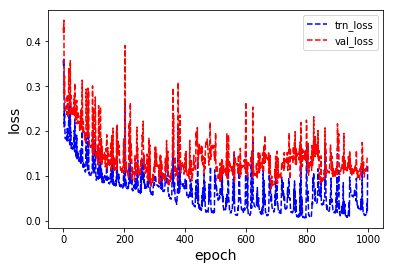

In [3]:
parser = get_args_parser()
args = parser.parse_args(args=[])
if torch.cuda.is_available():
    print(" -- GPU is available -- ")

# split the training data into 86:22 for training and validation respectively
trn_set = Battery_Dataset(train=True, last_padding=False)
val_set = Battery_Dataset(train=False, last_padding=False)
trn_loader = DataLoader(trn_set, batch_size=86, num_workers=1, drop_last=False, shuffle=False)
val_loader = DataLoader(val_set, batch_size=22, num_workers=1, drop_last=False, shuffle=False)

"""
real training strategy: we trained and save several models with CosineAnnealingLR
-> load the best model in the previous stage as pretrain weight and decrease the lr for fine-tuning
the best validation RUL error in this example can achieve ~35 cycles(RMSE)
"""
if args.finetune: # load pretrained weight, but in this example, we trained from scratch
    model = torch.load(args.pretrained_model)
else:
    model = Predictor(args.qv_ch, 1, drop=args.drop)
model.cuda()
summary(model, (args.qv_ch, 50))

optimizer = optim.AdamW(model.parameters(), lr=args.lr, amsgrad=True, weight_decay=args.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=args.lr_period, eta_min=args.min_lr)
criterion = nn.HuberLoss(delta=1)

best_rmse = 50
trn_loss_record, val_loss_record = [], []
for epoch in range(args.epochs):
    epoch += 1
    # in the training process, we use "last padding" for augmentation
    trn_random_set = Battery_Dataset(train=True, last_padding=True)
    trn_random_loader = DataLoader(trn_random_set, batch_size=args.batch_size, num_workers=1, drop_last=False, shuffle=True)
    model.train()
    batch = 0
    n_minibatch = (len(trn_random_set)//args.batch_size)
    for inputs, targets in trn_random_loader:
        batch += 1
        optimizer.zero_grad()
        output = model(inputs.cuda().float())
        loss = criterion(output , targets.reshape(-1, 1).cuda().float())
        loss.backward()
        optimizer.step()
        if batch%30==0:
            print('epoch:[%d / %d] batch:[%d / %d] loss= %.3f' % 
                (epoch, args.epochs, batch, n_minibatch, loss.mean()))

    if args.lr_schedule:
        scheduler.step()

    # model evaluation per epoch
    model.eval()
    with torch.no_grad():
        trn_loss, val_loss = 0, 0
        for inputs, targets in trn_loader:
            output = model(inputs.cuda().float())
            loss = criterion(output , targets.reshape(-1, 1).cuda().float())
            trn_loss += loss.mean()
        for inputs, targets in val_loader:
            output = model(inputs.cuda().float())
            loss = criterion(output , targets.reshape(-1, 1).cuda().float())
            val_loss += loss.mean()
        trn_loss_record.append(trn_loss.cpu())
        val_loss_record.append(val_loss.cpu())
        if epoch%args.detail_epoch==0:
            for g in optimizer.param_groups:
                current_lr = g['lr']
            print('100 cycles trn_loss: %.3f, val_loss: %.3f, lr=%e' % (trn_loss, val_loss, current_lr))

    # we can evaluate the RUL RMSE with different input cycle length
    trn_rmse, test_rmse = model_evaluation(model, eval_length=[0, 9, 49])
    if epoch%args.detail_epoch==0:
        print('training set RMSE 1 cycle: %.3f, 10 cycle: %.3f, 100 cycle: %.3f' %
            (trn_rmse[0], trn_rmse[1], trn_rmse[2]))
        print('testing set RMSE 1 cycle: %.3f, 10 cycle: %.3f, 100 cycle: %.3f' %
            (test_rmse[0], test_rmse[1], test_rmse[2]))

    # save the model with lowest validation RMSE
    if test_rmse[2]<best_rmse:
        best_rmse = test_rmse[2]
        torch.save(model, 'checkpoint/checkpoint'+str(test_rmse[2])+'.pth')

# training finished 
loss_profile(trn_loss_record, val_loss_record)